## EDA and Feature Engineering on the processed dataset

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [127]:
# Read in the data
GEO = "texas"
df = pd.read_csv(f"../../data/processed/{GEO}_processed.csv")
df.description = df.description.apply(lambda x: eval(x))
df.comments = df.comments.apply(lambda x: eval(x))
df.head()

,review_id,listing_id,description,comments,sentiment,label,name,amenities
0,83097,5456,"[fabulous, location, walking, convention, cent...","[sylvia, very, nice, informal, relaxed, arrive...",4.333333,no,"['walk', '6th', 'rainey', 'st', 'convention', ...","['TV', 'Wifi', 'Air conditioning', 'Kitchen', ..."
1,133337,5456,"[fabulous, location, walking, convention, cent...","[sylvia, picked, airport, gave, beautiful, eve...",4.000000,no,"['walk', '6th', 'rainey', 'st', 'convention', ...","['TV', 'Wifi', 'Air conditioning', 'Kitchen', ..."
2,150928,5456,"[fabulous, location, walking, convention, cent...","[lovely, time, enjoyed, apartment, clean, spac...",3.000000,no,"['walk', '6th', 'rainey', 'st', 'convention', ...","['TV', 'Wifi', 'Air conditioning', 'Kitchen', ..."
3,2706775,5456,"[fabulous, location, walking, convention, cent...","[sylvia, excellent, host, stayed, touch, made,...",4.500000,no,"['walk', '6th', 'rainey', 'st', 'convention', ...","['TV', 'Wifi', 'Air conditioning', 'Kitchen', ..."
4,8602878,5456,"[fabulous, location, walking, convention, cent...","[place, cute, little, self, contained, cottage...",4.000000,no,"['walk', '6th', 'rainey', 'st', 'convention', ...","['TV', 'Wifi', 'Air conditioning', 'Kitchen', ..."


### Distribution of labels

First, let's look at the distribution of labels in the processed dataset.

% of data with label 'yes': 13.58


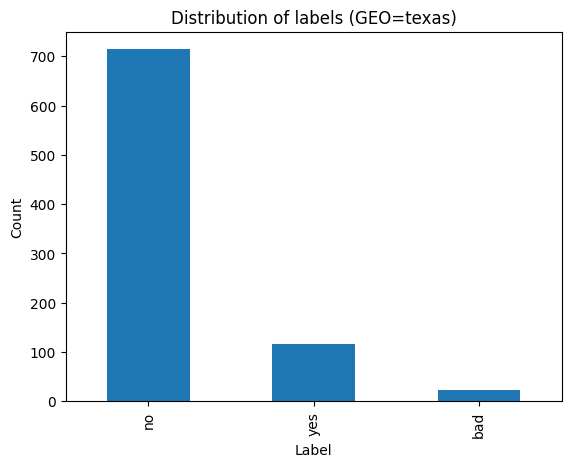

In [128]:
print(
    "% of data with label 'yes':", 
    round((len(df[df.label == "yes"])/len(df))* 100, 2)
)

fig = df.label.value_counts().plot(kind="bar")
fig.set_title(f"Distribution of labels (GEO={GEO})")
fig.set_xlabel("Label")
fig.set_ylabel("Count")
plt.show()

### Ngrams

What are the most common ngrams for the different types of reviews? What are the most common overlaps?

In [129]:
def get_consecutive_ngrams(review, n) -> list:
    """Helper function to get ngrams from a review.

    Args:
        review (str): The review to get ngrams from.
        n (int): The number of ngrams to get.

    Returns:
        list: the list of ngrams, joined by underscores.
    """
    if isinstance(review, str):
        review = review.split("")

    return ["_".join(review[i:i+n]) for i in range(len(review)-n-1)]

def series_to_ngrams(series: pd.Series, N):
    n_grams = series.apply(lambda x: get_consecutive_ngrams(x, N))
    return n_grams.explode()

Let's compare the number of overlapping ngrams between label types in a tri-venn diagram.

In [130]:
from matplotlib_venn import venn3
import imageio.v2 as imageio

def tri_venn_to_gif(ns):
    """Helper function to create a gif of a 3-way venn diagram for different Ns for N-grams. Returns a list of intersection sizes for each n.

    Args:
        ns (list): The list of ns to use for creating ngrams.
    """

    intersection_sizes = []

    for n in ns:

        yes_ngrams = series_to_ngrams(df[df.label == "yes"].comments, n).value_counts()
        no_ngrams = series_to_ngrams(df[df.label == "no"].comments, n).value_counts()
        bad_ngrams = series_to_ngrams(df[df.label == "bad"].comments, n).value_counts()

        fig = venn3(
            subsets=(
                set(yes_ngrams.index),
                set(no_ngrams.index),
                set(bad_ngrams.index)
            ),
            set_labels=("Yes", "No", "Bad")
        )

        fig.get_patch_by_id('100').set_color('green')
        fig.get_patch_by_id('010').set_color('red')
        fig.get_patch_by_id('001').set_color('orange')

        # get patch text 
        yes_size = fig.get_label_by_id('100').get_text()
        no_size = fig.get_label_by_id('010').get_text()
        bad_size = fig.get_label_by_id('001').get_text()
        intersection_sizes.append({
            "yes": yes_size,
            "no": no_size,
            "bad": bad_size,
            "n": n
        })

        plt.title(f"Venn diagram of # unique {n}-grams for different labels (GEO={GEO})")
        plt.savefig(f"../../figures/venns/venn_{n}-grams_{GEO}.png")
        plt.close()
    
    # create gif
    images = []
    for n in ns:
        images.append(imageio.imread(f"../../figures/venns/venn_{n}-grams_{GEO}.png"))
    imageio.mimsave(f"../../figures/venns/venn_{GEO}.gif", images, fps=1)

    return intersection_sizes
    

intersection_sizes = tri_venn_to_gif([1, 2, 3, 4, 5, 6])

In [131]:
from ipywidgets import widgets

with open(f"../../figures/venns/venn_{GEO}.gif", "rb") as file:
    # read file as string into `image` 
    image = file.read()

widgets.Image(
    value=image,
    format='gif'
)

Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00\xff\xff\xff\xff\xfe\xfe\xfe\xfe\xfe\xff\xfd\xfd\xff\xfb\xfa\x…

There are TONS of ngrams that are only in "no" (good reviews). There are no unique ngrams to "bad" reviews. There are a few unique ngrams to "yes" reviews. In addition to the gif, we can look at the number of unique values to each label over time on a line chart.

In [132]:
import plotly.express as px

# prepare data
is_df = pd.DataFrame(intersection_sizes)
is_df = is_df.melt(id_vars="n", var_name="label", value_name="count")
is_df["count"] = is_df["count"].astype(int)
is_df["n"] = is_df["n"].astype(int)

# only look at the size of "yes" labels
is_df_yes = is_df[is_df.label == "yes"]

# plot a line chart
px.line(is_df_yes, 
    x="n", y="count",
    title=f"Unique # of {GEO} n-grams for \"Yes\" labels", 
    labels={"n": "N-gram size", "count": "Unique # of n-grams"},
    markers=True
    )

We can see that the number of unique ngrams for "yes" increases until about n=3, and then levels off. Let's look at what these ngrams are in a wordcloud.

Now let's look at a word cloud of the 3-grams in misleading reviews.

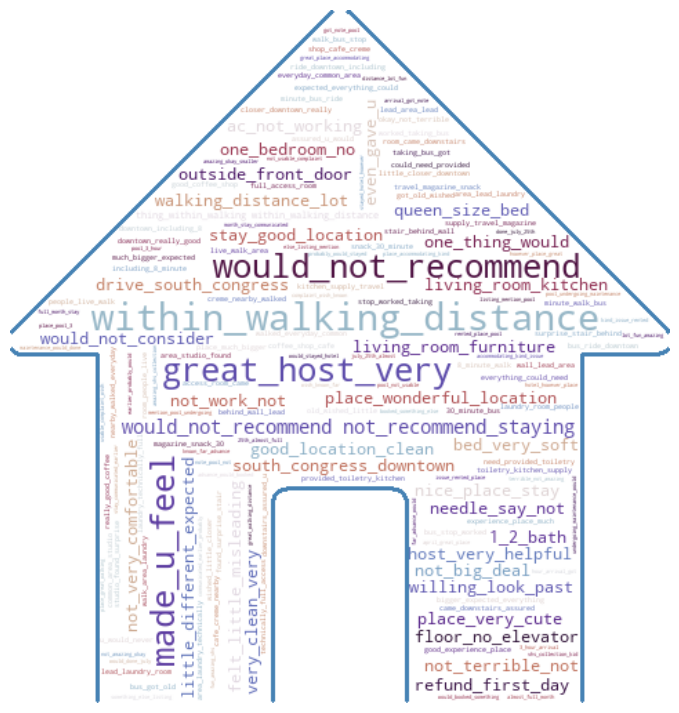

In [133]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

# generate wordcloud for misleading reviews
subset = df[df.label == "yes"]

# get groups of N consecutive words
N = 3
ngrams_str = " ".join(series_to_ngrams(subset.comments, N).to_list())

# make house-shaped mask
mask = np.array(Image.open("../../house_shape.png"))
# fill transparent areas with white
mask[mask[:, :, 3] == 0] = [255, 255, 255, 255]

# generate wordcloud
wc = WordCloud(
    background_color="white", 
    max_words=1000, 
    width=mask.shape[0]*5,
    height=mask.shape[1]*5,
    mask = mask,
    contour_width=3,
    contour_color='steelblue',
    colormap="twilight_shifted"
).generate(ngrams_str)

# show wordcloud using matplotlib
plt.figure(figsize=(15,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()